# k-SVD and other "topic models" with word embeddings

Topic modeling is a very popular natural language processing (NLP) technique to identify topics or themes in documents. For example, a corpus of newspaper articles covering US politics may have themes of healthcare, elections, protests, and foreign policy. The most common topic models, such as latent Dirichlet allocation (LDA), generate these through a document-term matrix, where rows represent documents and columns represent terms present in those documents. In LDA, a topic is a probability distribution across terms that best explains the document-term matrix. For example, the terms medicine, doctor, and insurance may have high probabilities within the healthcare topic. Each document is viewed as a random mixture of topics.

LDA was proposed in 2003, and in 2021, most state-of-the-art NLP models represent words in a many-dimensional vector space, known as "word embeddings." This contains much more information than the document-term matrix, which simplifies each document as a "bag of words" where word order does not matter. Several papers have been published in the past few years proposing topic models that make use of word embeddings. Our project focuses on one such technique that applies k-SVD (a combination of k-means and SVD) on the word embeddings. We adapt code from the paper proposing this technique (paper: https://arxiv.org/abs/1601.03764, code: https://github.com/PrincetonML/SemanticVector/tree/master/src/topic), also incorporating code from a UCLA team working on this (unpublished).

We compare this to conventional "bag of words" topic models and other techniques proposed to date for topic models with word embeddings:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models)](https://arxiv.org/abs/2004.14914)

### Import Packages

In [42]:
#General packages
import os
import pickle
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

#Gensim
import gensim
from gensim import similarities
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases

#ksvd
from src.ksvd_main import ApproxKSVD

## k-SVD application on a subset of the _News on the Web_ corpus
The subset includes 72,951 newspaper articles mentioning "artificial intelligence," "machine learning," or "deep learning”. 
For k-SVD, we will be using a 300 dimensional representation of 25,730 words that are extracted using Gensim's Word2Vec implementation.

In [43]:
#aiW2VPhrased.bin is a word embedding based on newspaper articles that mention "artificial intelligence," "machine learning," or "deep learning."
# model_path = 'data/aiW2VPhrased.bin'
model_path = 'data/aiW2V.bin'
w2v = KeyedVectors.load_word2vec_format(model_path, limit=25730, binary=True)

#Where you would like the k-SVD model to be stored
save_location = 'output/ksvd/'

In [44]:
n_phrase, dim = w2v.vectors.shape
print(f"Number of words and phrases in the vocabulary: {n_phrase}")
print(f"Dimension of the semantic space: {dim}")

Number of words and phrases in the vocabulary: 25730
Dimension of the semantic space: 300


In [45]:
def do_aksvd(w2v, n_topics, n_words, save=False, save_location=save_location):
    '''
    Runs k-SVD on a given 

    Inputs:
        w2v (Gensim keyedvectors): word embeddings
        n_topics (int): Number of components/topics (i.e., atoms, or dictionary elements)
        n_words (int): Number of nonzero coefficients to target (how many atoms each word can load onto)
        save (boolean): Whether to save the k-SVD output or not
        save_location (str): The directory to save the model output
    Outputs:
    
    '''
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    np.random.seed(123)
    aksvd_t = ApproxKSVD(num_topics=n_topics, num_words=n_words)
    
    # Dictionary is the matrix of discourse atoms. 
    # Weights contain the loadings of each word onto the discourse atoms.
    dictionary_t, weights = aksvd_t.fit(w2v.vectors) 
    
    if not os.path.exists(save_location):
        os.makedirs(save_location)
    
    if save==True:
        outfile = open(str(save_location) + '300d_' + str(n_topics) + 'comp' + str(n_words) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(save_location) + '300d_' +str(n_topics) + 'comp' + str(n_words) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(save_location) + '300d_' + str(n_topics) + 'comp' + str(n_words) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(weights,outfile)
        outfile.close()
    return(dictionary_t, weights)

In [46]:
# Quality check functions
def reconst_qual(w2v, dictionary_mat, weight_mat):
    
    #reconstruct the word vectors
    reconstructed = weight_mat.dot(dictionary_mat) 

    #total VARIANCE in the data: sum of squares 
    centered = w2v.vectors - np.mean(w2v.vectors, axis=1).reshape(-1,1)
    tot_var = np.sum(np.square(centered))

    #total sum of squared ERRORS/residuals
    err = [reconstructed[i] - w2v.vectors[i] for i in range(0, len(w2v.vectors))]
    sse = np.sum(np.square(err))

    #R^2: 1- (SSE / SST )
    r2 = 1 - (sse / tot_var)

    #compute root mean square error
    rmse = math.sqrt(np.mean(np.square(err)))

    return(sse, rmse, r2)


def topic_diversity(w2v, dictionary_mat, top_n=25):

    #topic diversity (% unique words among total closest 25 words to each atom)

    #list of list, each inner list includes top N words in that topic
    topwords = [] 

    for i in range(0, len(dictionary_mat)):
        topwords.extend([i[0] for i in w2v.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 

    uniquewords = set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [92]:
w = [5, 10, 20]
t = [20, 50, 100, 200]
metrics = {}
for n_words in w:
    for n_topics in t: 
        dictionary_t, weights = do_aksvd(w2v=w2v, n_topics=n_topics, n_words=n_words, save=True)
        sse, rmse, r2 = reconst_qual(w2v=w2v, dictionary_mat=dictionary_t, weight_mat=weights)
        div = topic_diversity(w2v, dictionary_t, top_n=100)
        metrics['n_words'] = metrics.get('n_words', []) + [n_words]
        metrics['n_topics'] = metrics.get('n_topics', []) + [n_topics]
        metrics['sse'] = metrics.get('sse', []) + [sse]
        metrics['rmse'] = metrics.get('rmse', []) + [rmse]
        metrics['r2'] = metrics.get('r2', []) + [r2]
        metrics['div'] = metrics.get('div', []) + [div]

/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return f(*args, **kwargs)
/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return f(*args, **kwargs)
/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return f(*args, **kwargs)
/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: RuntimeWarning:  Orthogonal matching pursuit ended prematurely du

Text(0.5, 1.0, 'R2 by number of topics and words')

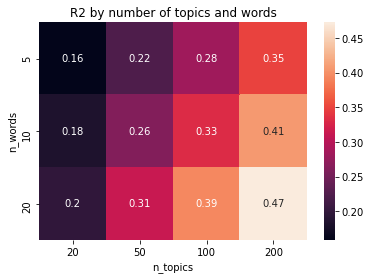

In [93]:
metrics_df = pd.DataFrame(metrics)
r2_pivot = metrics_df[['n_words', 'n_topics', 'r2']].pivot(index='n_words', columns='n_topics', values='r2')
sns.heatmap(r2_pivot, annot=True)
plt.title('R2 by number of topics and words')

Expectedly, R2 increases with the number of words we aim to use in defining an atom (topic). R2 also increases with the number of topics. This is because as the number of topics approaches to the number of words/phrases we have in our Word2vec dictionary, it structurally gets closer to our semantic space. 

Text(0.5, 1.0, 'Topic diversity by number of topics and words')

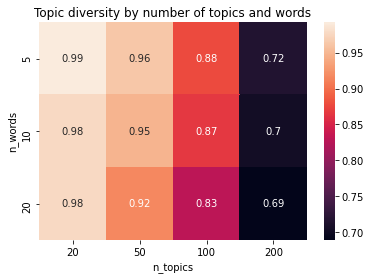

In [94]:
div_pivot = metrics_df[['n_words', 'n_topics', 'div']].pivot(index='n_words', columns='n_topics', values='div')
sns.heatmap(div_pivot, annot=True)
plt.title('Topic diversity by number of topics and words')

Topic diversity decreases with the number of topics. As we increase the number of topics, the topics become more and more similar to each other and start to share more words/phrases.

I will pick the k-SVD model where n_words = 20, and n_topics = 100. 

In [47]:
with open('output/ksvd/300d_100comp20nonzeros_dictionary_nvdrsdf20', 'rb') as data:
     dictionary_t = pickle.load(data)
with open('output/ksvd/300d_100comp20nonzeros_alpha_nvdrsdf20', 'rb') as data:
     weights = pickle.load(data)

In [48]:
#List the discourse atoms and their most similar words.
similar_words = 25
atoms_dict = {}

for i in range(0, len(dictionary_t)):
    atoms_dict["Discourse Atoms"] = atoms_dict.get("Discourse Atoms", []) + ["Discourse_Atom " + str(i)]
    most_sim = [j[0] for j in w2v.similar_by_vector(dictionary_t[i],topn=similar_words)]
    for k in range(len(most_sim)):
        atoms_dict[k] = atoms_dict.get(k, []) + [most_sim[k]]

atoms_df = pd.DataFrame(atoms_dict)

In [49]:
atoms_df.sample(n=10, random_state=42).iloc[:, :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
83,Discourse_Atom 83,lcd,a14,thunderbolt,15-inch,bezels,processor,thinner,touchscreen,55-inch,octa
53,Discourse_Atom 53,las,sundar,moderator@wsj.com,hailing,unanswered,fuels,allergen,pakatan,beverage,cheetah
70,Discourse_Atom 70,xeon,i7,volta,sedans,suvs,optane,prius,suv,audi,chevrolet
45,Discourse_Atom 45,collected,carmaker,collecting,gathers,powertrain,suv,terabytes,collection,vehicle,troves
44,Discourse_Atom 44,streamlining,duplication,inefficiency,municipal,administrative,solving,inefficiencies,grasping,reusable,bureaucratic
39,Discourse_Atom 39,gather,losses,changes,improvements,collect,difference,dislocation,quantities,explosion,extracts
22,Discourse_Atom 22,alto,activision,sunnyvale,sacramento,irvine,lecturer,invaders,cryo,researcher,ojo
80,Discourse_Atom 80,mehrotra,krishnan,narayanan,rao,srinivasan,gupta,atul,sumit,chatterjee,prashant
10,Discourse_Atom 10,farm,farms,livestock,dairy,growers,poultry,plant,agricultural,crops,wheat
0,Discourse_Atom 0,engines,headings,toolkits,sagemaker,engine,codeguru,plugin,git,lambda,bing


## LDA Topic Modeling

In [241]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [242]:
cols_list = ['id', 'length', 'date', 'country', 'publisher', 'url', 'title', 'text', 'reduced_tokens', 'year', 'month', 'day']

df = pd.read_csv(
    'data/aiTextsWithTokens.csv', 
    usecols=cols_list    
    )

In [243]:
df = df[~df.reduced_tokens.str.contains('\...')]
df.reset_index(drop=True, inplace=True)
df.shape

(72226, 12)

In [155]:
convert = lambda x: eval(x.replace(' ', ',')) if x != '' else x
tokens = list(df['reduced_tokens'].apply(eval_token))

TypeError: 'list' object is not callable

In [89]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)

# Create Corpus
corpus = [id2word.doc2bow(token) for token in tokens]

Building LDA with the same number of topics (atoms) as k-SVD

In [103]:
# Build LDA model
n_topics = 100
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Save LDA related objects

In [165]:
save_location = 'output/lda/'

outfile = open(str(save_location) + 'lda_model','wb')
pickle.dump(lda_model,outfile)
outfile.close()

outfile = open(str(save_location) + 'id2word','wb')
pickle.dump(id2word,outfile)
outfile.close()

outfile = open(str(save_location) + 'corpus','wb')
pickle.dump(corpus,outfile)
outfile.close()

/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# with open('output/lda/corpus', 'rb') as data:
#     corpus = pickle.load(data)

# with open('output/lda/id2word', 'rb') as data:
#     id2word = pickle.load(data)

# with open('output/lda/lda_model', 'rb') as data:
#     lda_model = pickle.load(data)

In [35]:
topic_dict = {'topic': []}
for i in range(n_topics): 
    topic_dict['topic'].append(i)
    words = re.sub(r'\d+.\d+\*', '', lda_model.print_topic(i)).replace('"', '').replace(' ', '').split('+')
    for j in range(len(words)):
        topic_dict[j] = topic_dict.get(j, []) + [words[j]]

In [37]:
topic_df = pd.DataFrame(topic_dict)
topic_df.sample(n=10, random_state=1).sort_values('topic')

,topic,0,1,2,3,4,5,6,7,8,9
17,17,air,autonomous,force,war,military,control,power,mission,general,fully
33,33,content,search,engine,relevant,web,article,online,result,overall,moment
36,36,school,trust,high,great,overall,moment,quality,middle,easy,review
65,65,city,york,london,central,area,place,population,daily,outside,home
69,69,algorithm,canada,quality,decision,easy,great,middle,moment,overall,progress
80,80,case,result,term,example,level,set,issue,point,control,order
81,81,business,market,supply,chain,value,management,opportunity,global,strategy,competitive
82,82,health,patient,medical,healthcare,care,disease,clinical,heart,population,early
84,84,industry,sector,energy,efficient,efficiency,partnership,commercial,huge,distribution,power
93,93,company,tech,ceo,firm,executive,group,chief,partnership,base,officer


In [149]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -6.749722621529295


In [151]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

Traceback (most recent call last):
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 405, in _send_bytes
    self._send(buf)
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/egemenpamukcu/opt/anaconda3/lib/py


Coherence Score:  0.2932872950740005


In [152]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2932872950740005


## Visualization of LDA Topics
Significant bit of overlap between topics. k-SVD seems to sustain more topic diversity when number of topics is high. 

In [157]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/egemenpamukcu/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
75    -0.247023  0.031140       1        1  9.635001
2     -0.289064 -0.064288       2        1  7.770793
80    -0.256519 -0.029816       3        1  7.609357
6     -0.218654  0.050401       4        1  6.307672
8     -0.259910  0.082702       5        1  6.213104
...         ...       ...     ...      ...       ...
59     0.058549  0.006220      96        1  0.168245
26     0.013016 -0.007493      97        1  0.150178
56     0.038137  0.019246      98        1  0.148517
49     0.049689  0.011072      99        1  0.134405
12     0.058130  0.006166     100        1  0.118317

[100 rows x 5 columns], topic_info=          Term           Freq          Total  Category  logprob  loglift
96         say  222220.000000  222220.000000   Default  30.0000  30.0000
253    company  186257.000000  186257.000000   Default  29.0000  29.0000
124       work  133776.000000  133776.000000   Default  28.0000  28.0000
242   business  118821.000000  118821.000000   Default  27.0000  27.0000
61       learn  116232.000000  116232.000000   Default  26.0000  26.0000
..         ...            ...            ...       ...      ...      ...
23     despite       0.012916    8991.499681  Topic100 -14.1255  -6.7138
24   detection       0.012916    9401.735744  Topic100 -14.1255  -6.7584
25      device       0.012916   37627.228944  Topic100 -14.1255  -8.1452
26     digital       0.012916   73124.664870  Topic100 -14.1255  -8.8096
27       drive       0.012916   49881.637414  Topic100 -14.1255  -8.4271

[4967 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
392      66  0.999845       3d
0         1  0.028987  ability
0         2  0.003036  ability
0         3  0.071977  ability
0         5  0.416488  ability
...     ...       ...      ...
495      37  0.000857    worth
125       4  0.999990     year
391      67  0.999885     york
126      18  0.991777    young
126      44  0.008145    young

[2084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[76, 3, 81, 7, 9, 86, 94, 92, 100, 82, 80, 68, 75, 17, 72, 33, 55, 26, 49, 32, 73, 85, 21, 83, 25, 20, 87, 14, 41, 45, 42, 61, 90, 99, 93, 23, 22, 16, 89, 44, 51, 36, 12, 88, 69, 84, 67, 53, 96, 95, 19, 8, 34, 64, 18, 91, 59, 30, 2, 28, 1, 77, 71, 15, 62, 4, 66, 74, 97, 48, 47, 39, 70, 10, 58, 98, 65, 56, 63, 54, 37, 5, 29, 24, 52, 31, 79, 6, 46, 40, 78, 11, 43, 38, 35, 60, 27, 57, 50, 13])

# Topic assignment comparisons

In [159]:
def get_document_vector(w2v, ds):
    docs_vec = np.zeros((len(ds), w2v.vector_size))
    for i, d in enumerate(ds):
        doc = eval(d.replace(' ', ','))
        doc_vec = np.zeros((len(doc), w2v.vector_size))
        for j, word in enumerate(doc):
            try: 
                doc_vec[j] = w2v[word]
            except KeyError:
                continue
        doc_vec = doc_vec[~np.all(doc_vec == 0, axis=1)].mean(axis=0)
        docs_vec[i] = doc_vec
    
    return docs_vec



In [162]:
docs_vec = get_document_vector(w2v, df['reduced_tokens'])

In [170]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(docs_vec, dictionary_t)

In [189]:
import heapq

get_best_atoms = lambda v: heapq.nlargest(3, range(len(v)), v.take)

In [194]:
best_atoms_per_doc = np.apply_along_axis(get_best_atoms, 1, sim_matrix)

In [211]:
def get_best_topics(corpus): 
    best_topics = []
    for doc in corpus: 
        topics = lda_model.get_document_topics(doc)
        top3 = [pair[0] for pair in sorted(topics, key=lambda x: x[1], reverse=True)[:3]]
        best_topics.append(top3)
    return best_topics

In [212]:
best_topics_per_doc = get_best_topics(corpus)

## Example 1

Now we can have a look at the atoms most similar to a document as well as topics most dominant in a vector 

In [248]:
idx = np.random.randint(0, df.shape[0])
print(df.loc[idx, 'text'][:1000])

<h> Ravens guard John Urschel starts work on Ph.D . at MIT <p> Ravens guard John Urschel is two years into his NFL career and is going to back to college to earn a degree . His third degree . <p> Ravens guard John Urschel is two years into his NFL career and is going to back to college to earn a degree . His third degree . <p> After receiving his bachelor 's degree in mathematics from Penn State in three years , Urschel spent the next two years earning a master 's degree and working on a second master 's . But now he 's going for his doctorate from the prestigious Massachusetts Institute of Technology . <p> Urschel tweeted Tuesday afternoon that he has begun work on a Ph.D . with a focus on spectral graph theory , numerical linear algebra , and machine learning from MIT . <p> Urschel was a fifth-round draft pick of the Ravens in 2014 and has started 10 games , including seven this past season . The Buffalo native was a three-time academic All-Big Ten selection and twice earned @ @ @ @ 

LDA Topics for this article are:

In [262]:
topic_df.iloc[best_topics_per_doc[idx], :]

,topic,0,1,2,3,4,5,6,7,8,9
6,6,year,month,day,late,end,early,come,plan,week,big
98,98,job,work,workforce,career,professional,staff,people,demand,shift,manager
2,2,help,development,lead,work,support,innovation,focus,include,leader,global


k-SVD atoms closest to this article is: 

In [265]:
atoms_df.iloc[best_atoms_per_doc[idx], :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
81,Discourse_Atom 81,hire,hired,recruit,hires,recruiting,hiring,founders,backgrounds,interns,poached
90,Discourse_Atom 90,deserving,honors,books,festivals,essays,sponsorships,endorsements,earned,handpicked,graced
88,Discourse_Atom 88,springboks,playoff,wallabies,touchdown,week,totals,tournament,inning,matric,season


## Example 2

In [266]:
idx = np.random.randint(0, df.shape[0])
print(df.loc[idx, 'text'][:1000])

<h> Agricultural innovation group moves on after federal funding snub <p> Manitoba was shut out of the federal government 's $950-million Innovation Superclusters Initiative , but provincial officials are now looking to partner with others among the nine shortlisted proposals . <p> Ray Bouchard , chairman of the Manitoba community group that organized around the initiative called Enterprise Machine Intelligence and Learning Initiative ( EMILI ) , said everyone involved was disappointed . <p> But he said they were cautiously optimistic that EMILI and/or some of the components of the group will be able to partner with groups behind agriculture-related proposals shortlisted out of Saskatchewan and Alberta . <p> EMILI is an initiative focused on commercialization strategies and skills training around artificial intelligence ( AI ) and machine-learning technologies . An AI entry out of Montreal was also on the short list . <p> Subscribers Log in below to continue reading , not a subscriber 

In [267]:
topic_df.iloc[best_topics_per_doc[idx], :]

,topic,0,1,2,3,4,5,6,7,8,9
2,2,help,development,lead,work,support,innovation,focus,include,leader,global
80,80,case,result,term,example,level,set,issue,point,control,order
75,75,people,work,way,think,know,look,want,come,thing,good


In [268]:
atoms_df.iloc[best_atoms_per_doc[idx], :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
93,Discourse_Atom 93,innovations,impetus,initiatives,prosperity,desire,economies,agenda,strategies,ideas,ways
75,Discourse_Atom 75,incubate,conservation,aquaculture,commercialisation,commercialise,develop,pesticides,planting,incubation,refine
56,Discourse_Atom 56,amounted,expenditures,approximately,total,fy18,ebit,us$,fy20,expenditure,r&amp;d


## Example 3

In [272]:
idx = np.random.randint(0, df.shape[0])
print(df.loc[idx, 'text'][:1000])

<p> Nothing stands still , and smartphone cameras are expected to continue to evolve in 2018 . Dual cameras are tipped to become the norm for many flagship phones . <p> The reasons for this come down to size . There 's not enough room on the back of a smartphone to mount a decent-sized camera lens and have the phone stay pocketable . <p> Advertisement <p> Also , smaller lenses limit the amount of detail that can be captured . Adding a second camera allows the smartphone to capture images as if a much larger lens was used . <p> ARTIFICIAL INTELLIGENCE/AUGMENTED REALITY <p> Tech leaders hyped artificial intelligence throughout 2017 . It might not be anything new ( we 've had Siri , Google Assistant and Cortana for a few years already ) , but it will come of age this year as smartphone makers build it into a growing array of smartphone functionality . <p> Huawei is already doing this with the Mate 10 which has a dedicated AI processor called the NPU ( neural processing unit ) . For exampl

In [273]:
topic_df.iloc[best_topics_per_doc[idx], :]

,topic,0,1,2,3,4,5,6,7,8,9
43,43,camera,screen,display,light,video,vision,price,version,late,generation
58,58,iphone,phone,smartphone,come,fast,launch,offer,hardware,device,main
6,6,year,month,day,late,end,early,come,plan,week,big


In [274]:
atoms_df.iloc[best_atoms_per_doc[idx], :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
83,Discourse_Atom 83,lcd,a14,thunderbolt,15-inch,bezels,processor,thinner,touchscreen,55-inch,octa
87,Discourse_Atom 87,stroke,dementia,symptoms,stereo,macular,retinal,ultrasound,epilepsy,bladder,wristband
98,Discourse_Atom 98,nuclei,spatially,i.e.,measurements,intensities,morphology,parameters,reconstructions,wavelengths,linearly


## Example 4

In [284]:
idx = np.random.randint(0, df.shape[0])
print(df.loc[idx, 'text'][:1000])

<h> Temasek backs $100m Series C in US AI firm SparkCognition <p> US-based artificial intelligence ( AI ) startup SparkCognition has raised $100 million in its Series C funding round led by Los Angeles-based venture capital firm March Capital Partners and backed by existing and new investors , including Singapore 's state investor Temasek Holdings . <p> The latest funding , which brings the Texas AI startup 's total money raised to $175 million , will further boost the company 's offering , especially in cognitive computing analysis , according to a statement . <p> The said products unlock insights and make predictions based on historical maintenance data and logs , and protect companies from cyber threats , the company said . <p> " We enable our customers to weave AI into the fabric of their organizations . We work together to build human-level intelligence applied at machine scale to optimize operations and find new solutions to old problems , " SparkCognition said on its website . <

In [285]:
topic_df.iloc[best_topics_per_doc[idx], :]

,topic,0,1,2,3,4,5,6,7,8,9
35,35,startup,venture,startups,capital,founder,fund,partner,stage,start,base
6,6,year,month,day,late,end,early,come,plan,week,big
93,93,company,tech,ceo,firm,executive,group,chief,partnership,base,officer


In [286]:
atoms_df.iloc[best_atoms_per_doc[idx], :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
5,Discourse_Atom 5,bdc,sequoia,j.p,naspers,ventures,jp,tpg,gic,pincus,gv
56,Discourse_Atom 56,amounted,expenditures,approximately,total,fy18,ebit,us$,fy20,expenditure,r&amp;d
64,Discourse_Atom 64,capitalization,capitalisation,otcqb,ticker,tivo,otc,adss,tranche,tsxv,aum


## Example 5

In [287]:
idx = np.random.randint(0, df.shape[0])
print(df.loc[idx, 'text'][:1000])

<p> By continuing to use this site you consent to the use of cookies on your device as described in our Cookie Policy unless you have disabled them . You can change your Cookie Settings at any time but parts of our site will not function correctly without them . <p> Leasing of warehousing space went up by over 45 per cent last year to cross 25 million sq ft in seven major cities , driven by e-commerce sector that accounted for 23 per cent of the total demand , according to property consultant CBRE . <p> CBRE Tuesday released its report ' Online retail driving realty Elevating the e-commerce game ' that examines the link between online retailing ( e-tailing ) and the logistics sector and the impact of GST on the leasing of warehousing spaces . <p> " The impressive growth of the e-commerce sector has been on the back of favourable policy reforms , tech-enhanced warehouses , rising smartphone and internet penetration , digital India movement , amongst others , " the report said . <p> The 

In [288]:
topic_df.iloc[best_topics_per_doc[idx], :]

,topic,0,1,2,3,4,5,6,7,8,9
99,99,increase,growth,high,rate,grow,demand,expect,low,region,rise
2,2,help,development,lead,work,support,innovation,focus,include,leader,global
81,81,business,market,supply,chain,value,management,opportunity,global,strategy,competitive


In [289]:
atoms_df.iloc[best_atoms_per_doc[idx], :11]

,Discourse Atoms,0,1,2,3,4,5,6,7,8,9
93,Discourse_Atom 93,innovations,impetus,initiatives,prosperity,desire,economies,agenda,strategies,ideas,ways
14,Discourse_Atom 14,colocation,aws,premise,premises,hyperscale,providers,ecs,rackspace,rent,provisioned
76,Discourse_Atom 76,youtube,downloads,messaging,instagram,douyin,spotify,video,snapchat,music,songs
